# GRU 301
Start with CNN 316 but use RNN like GRU 220.
Use one-hot (like CNN) rather than K-mer embedding (like RNN).

In [1]:
TRAIN_NC_FILENAME='ncRNA.gc36.long.fasta'
TRAIN_PC_FILENAME='pcRNA.gc36.long.fasta'
VALID_NC_FILENAME='ncRNA.gc36.short.fasta'
VALID_PC_FILENAME='pcRNA.gc36.short.fasta'
#NC_FILENAME='ncRNA.tiny50.fasta'
#PC_FILENAME='pcRNA.tiny50.fasta'
#NC_FILENAME='ncRNA.gc34.processed.fasta'
#PC_FILENAME='pcRNA.gc34.processed.fasta'

MODEL_FILE='JUNK1'  # change this if you want to keep models
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
TRAIN_NC_FILENAME = DATAPATH+TRAIN_NC_FILENAME
TRAIN_PC_FILENAME = DATAPATH+TRAIN_PC_FILENAME
VALID_NC_FILENAME = DATAPATH+VALID_NC_FILENAME
VALID_PC_FILENAME = DATAPATH+VALID_PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=200
SPLITS=5
ONEHOT=5  
NEURONS=64
DROP=0.10
ACT="tanh"
MINLEN=201
MAXLEN=2000
LIMIT=5588    # This is the size of our smallest set (protein coding short)

Mounted at /content/drive/


In [2]:
# Load our own tools
# TO DO: don't go to GitHub if the file is already local.
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [4]:
def compile_model(model):
    ## learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    #adam_default_learn_rate = 0.001
    #schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #    initial_learning_rate = adam_default_learn_rate*10,
    #    decay_steps=10000, decay_rate=0.99, staircase=True)
    #alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])

    print("COMPILE...")
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    MASK=[0,0,0,0,1] # to do: get one_hot('N') from the one_hot() function.
    mask_layer = keras.layers.Masking(mask_value=MASK, input_shape=[MAXLEN,ONEHOT])
    rlayer1 = keras.layers.GRU(NEURONS, return_sequences=True, 
        activation=ACT, dropout=DROP )  
    rlayer2 = keras.layers.GRU(NEURONS, return_sequences=True, 
        activation=ACT, dropout=DROP) 
    rlayer3 = keras.layers.GRU(NEURONS, return_sequences=True, 
        activation=ACT, dropout=DROP) 
    rlayer4 = keras.layers.GRU(NEURONS, return_sequences=False, 
        activation=ACT, dropout=DROP) 

    dlayer1 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer2 = keras.layers.Dropout(DROP)
    dlayer3 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer4 = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)

    rnn = keras.models.Sequential()
    rnn.add(mask_layer)
    rnn.add(rlayer1)
    rnn.add(rlayer2)
    rnn.add(rlayer3)
    rnn.add(rlayer4)
    rnn.add(dlayer1)
    rnn.add(dlayer2)
    rnn.add(dlayer3)
    rnn.add(dlayer4)
    rnn.add(output_layer)
    compiled = compile_model(rnn)
    return compiled

Cross validation

In [5]:
def do_cross_validation(X_train,y_train,given_model,X_valid,y_valid):
    cv_scores = []
    fold=0
    # When not using ShuffleSplit, make sure to randomize train data.
    #splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    #for train_index,valid_index in splitter.split(X):
    while fold < SPLITS:
        fold += 1
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        es = keras.callbacks.EarlyStopping(monitor='val_loss',  
            patience=10, verbose=1)
        mc = keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')  
        mycallbacks = [es,mc]  
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks, shuffle=True,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  

    print()
    print("%d-way Cross Validation max %.2f%%, mean %.2f%% (+/- %.2f%%)" % 
          (fold, np.amax(cv_scores), np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [6]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
#model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 2000, 5)           0         
_________________________________________________________________
gru (GRU)                    (None, 2000, 64)          13632     
_________________________________________________________________
gru_1 (GRU)                  (None, 2000, 64)          24960     
_________________________________________________________________
gru_2 (GRU)                  (None, 2000, 64)          24960     
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_____________________________________________________________

In [7]:
def load_data(nc_filename,pc_filename,limit=None):
  nc_seq=tools.load_fasta(nc_filename,0)
  pc_seq=tools.load_fasta(pc_filename,1)
  if limit is not None:
    # Choose a random subset of size = limit.
    # Side effect: randomizes the data order.
    nfrac=1.0*limit/len(nc_seq)
    pfrac=1.0*limit/len(pc_seq)
    if nfrac<1.0:
      nc_seq=nc_seq.sample(frac=nfrac)
    if pfrac<1.0:
      pc_seq=pc_seq.sample(frac=pfrac)
  train_set=pd.concat((nc_seq,pc_seq),axis=0)
  # May not need to slice by length if input files already sliced
  subset=tools.make_slice(train_set,MINLEN,MAXLEN)
  # randset=subset.sample(frac=1) # unneccessary with fit(shuffle)
  (X1,y1)=tools.separate_X_and_y(subset)
  # X1 is pandas df of ("list" of one sequence)
  X2=X1.to_numpy()  # numpy ndarray of ("list" of one sequence)
  X3=[elem[0] for elem in X2]  # numpy dnarray of str
  X4=tools.uniform_length(X3,MAXLEN)
  X5= [tools.one_hot(x) for x in X4]  
  # one-hot leaves ONEHOT=5. TO DO: set 5 automatically
  X6=np.asarray(X5)
  y6=y1.to_numpy()
  return X6,y6

print("Load train data from files.")
X_train,y_train = load_data(TRAIN_NC_FILENAME,TRAIN_PC_FILENAME,LIMIT)
print("X_train",X_train.shape)
print(X_train[1])
print("Load valid data from files.")
X_valid,y_valid = load_data(VALID_NC_FILENAME,VALID_PC_FILENAME,LIMIT)
print("X_valid",X_valid.shape)

Load train data from files.
X_train (11176, 2000, 5)
[[1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]
Load valid data from files.
X_valid (11176, 2000, 5)


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 141s 354ms/step - loss: 0.6926 - accuracy: 0.5153 - val_loss: 0.6864 - val_accuracy: 0.5486


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 2/200
350/350 [==============================] - 121s 345ms/step - loss: 0.6893 - accuracy: 0.5368 - val_loss: 0.6917 - val_accuracy: 0.5412
Epoch 3/200
350/350 [==============================] - 121s 345ms/step - loss: 0.6808 - accuracy: 0.5631 - val_loss: 0.6935 - val_accuracy: 0.5336
Epoch 4/200
350/350 [==============================] - 120s 342ms/step - loss: 0.6750 - accuracy: 0.5780 - val_loss: 0.6957 - val_accuracy: 0.5385
Epoch 5/200
350/350 [==============================] - 118s 339ms/step - loss: 0.6734 - accuracy: 0.5839 - val_loss: 0.6897 - val_accuracy: 0.5479
Epoch 6/200
350/350 [==============================] - 120s 342ms/step - loss: 0.6719 - accuracy: 0.5883 - val_loss: 0.6847 - val_accuracy: 0.5575


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 7/200
350/350 [==============================] - 119s 340ms/step - loss: 0.6682 - accuracy: 0.5942 - val_loss: 0.6848 - val_accuracy: 0.5511
Epoch 8/200
350/350 [==============================] - 120s 342ms/step - loss: 0.6660 - accuracy: 0.5930 - val_loss: 0.6887 - val_accuracy: 0.5540
Epoch 9/200
350/350 [==============================] - 119s 339ms/step - loss: 0.6640 - accuracy: 0.6035 - val_loss: 0.6826 - val_accuracy: 0.5539
Epoch 10/200
350/350 [==============================] - 118s 337ms/step - loss: 0.6622 - accuracy: 0.6081 - val_loss: 0.6842 - val_accuracy: 0.5574
Epoch 11/200
350/350 [==============================] - 118s 337ms/step - loss: 0.6651 - accuracy: 0.5962 - val_loss: 0.6836 - val_accuracy: 0.5548
Epoch 12/200
350/350 [==============================] - 119s 341ms/step - loss: 0.6616 - accuracy: 0.5992 - val_loss: 0.6961 - val_accuracy: 0.5475
Epoch 13/200
350/350 [==============================] - 119s 341ms/step - loss: 0.6583 - accuracy: 0.6058 - val_los

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 14/200
350/350 [==============================] - 117s 334ms/step - loss: 0.6532 - accuracy: 0.6185 - val_loss: 0.6864 - val_accuracy: 0.5707


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 15/200
350/350 [==============================] - 119s 341ms/step - loss: 0.6501 - accuracy: 0.6140 - val_loss: 0.6730 - val_accuracy: 0.5669
Epoch 16/200
350/350 [==============================] - 119s 339ms/step - loss: 0.6465 - accuracy: 0.6267 - val_loss: 0.7093 - val_accuracy: 0.5702
Epoch 17/200
350/350 [==============================] - 119s 340ms/step - loss: 0.6418 - accuracy: 0.6226 - val_loss: 0.6693 - val_accuracy: 0.5864


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 18/200
350/350 [==============================] - 120s 342ms/step - loss: 0.6524 - accuracy: 0.6093 - val_loss: 0.6894 - val_accuracy: 0.5581
Epoch 19/200
350/350 [==============================] - 118s 338ms/step - loss: 0.6507 - accuracy: 0.6139 - val_loss: 0.6828 - val_accuracy: 0.5610
Epoch 20/200
350/350 [==============================] - 118s 338ms/step - loss: 0.6497 - accuracy: 0.6308 - val_loss: 0.6744 - val_accuracy: 0.5659
Epoch 21/200
350/350 [==============================] - 119s 339ms/step - loss: 0.6409 - accuracy: 0.6283 - val_loss: 0.6811 - val_accuracy: 0.6025


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 22/200
350/350 [==============================] - 117s 336ms/step - loss: 0.5806 - accuracy: 0.7002 - val_loss: 0.6356 - val_accuracy: 0.6491


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 23/200
350/350 [==============================] - 119s 341ms/step - loss: 0.5247 - accuracy: 0.7410 - val_loss: 0.7202 - val_accuracy: 0.6330
Epoch 24/200
350/350 [==============================] - 118s 338ms/step - loss: 0.4918 - accuracy: 0.7618 - val_loss: 0.6470 - val_accuracy: 0.6845


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 25/200
350/350 [==============================] - 119s 339ms/step - loss: 0.4465 - accuracy: 0.7926 - val_loss: 0.6492 - val_accuracy: 0.6851


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 26/200
350/350 [==============================] - 118s 337ms/step - loss: 0.4145 - accuracy: 0.8104 - val_loss: 0.6504 - val_accuracy: 0.7215


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 27/200
350/350 [==============================] - 117s 336ms/step - loss: 0.3882 - accuracy: 0.8237 - val_loss: 0.5268 - val_accuracy: 0.7751


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 28/200
350/350 [==============================] - 118s 338ms/step - loss: 0.3654 - accuracy: 0.8378 - val_loss: 0.6511 - val_accuracy: 0.7371
Epoch 29/200
350/350 [==============================] - 118s 338ms/step - loss: 0.3670 - accuracy: 0.8361 - val_loss: 0.4633 - val_accuracy: 0.7922


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 30/200
350/350 [==============================] - 118s 337ms/step - loss: 0.3418 - accuracy: 0.8514 - val_loss: 0.4588 - val_accuracy: 0.7999


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 31/200
350/350 [==============================] - 118s 337ms/step - loss: 0.3179 - accuracy: 0.8642 - val_loss: 0.4705 - val_accuracy: 0.7886
Epoch 32/200
350/350 [==============================] - 118s 337ms/step - loss: 0.3123 - accuracy: 0.8661 - val_loss: 0.4040 - val_accuracy: 0.8369


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 33/200
350/350 [==============================] - 119s 339ms/step - loss: 0.3067 - accuracy: 0.8708 - val_loss: 0.4427 - val_accuracy: 0.8306
Epoch 34/200
350/350 [==============================] - 119s 342ms/step - loss: 0.2886 - accuracy: 0.8797 - val_loss: 0.4085 - val_accuracy: 0.8406


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 35/200
350/350 [==============================] - 118s 338ms/step - loss: 0.2757 - accuracy: 0.8853 - val_loss: 0.4086 - val_accuracy: 0.8363
Epoch 36/200
350/350 [==============================] - 118s 338ms/step - loss: 0.2744 - accuracy: 0.8845 - val_loss: 0.3731 - val_accuracy: 0.8492


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 37/200
350/350 [==============================] - 117s 335ms/step - loss: 0.2600 - accuracy: 0.8951 - val_loss: 0.3480 - val_accuracy: 0.8529


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 38/200
350/350 [==============================] - 118s 337ms/step - loss: 0.2492 - accuracy: 0.8995 - val_loss: 0.3983 - val_accuracy: 0.8453
Epoch 39/200
350/350 [==============================] - 118s 337ms/step - loss: 0.2423 - accuracy: 0.8981 - val_loss: 0.4539 - val_accuracy: 0.8197
Epoch 40/200
350/350 [==============================] - 119s 341ms/step - loss: 0.2681 - accuracy: 0.8891 - val_loss: 0.3535 - val_accuracy: 0.8669


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 41/200
350/350 [==============================] - 119s 340ms/step - loss: 0.2454 - accuracy: 0.9032 - val_loss: 0.3348 - val_accuracy: 0.8754


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 42/200
350/350 [==============================] - 117s 335ms/step - loss: 0.2356 - accuracy: 0.9070 - val_loss: 0.4052 - val_accuracy: 0.8487
Epoch 43/200
350/350 [==============================] - 120s 344ms/step - loss: 0.2233 - accuracy: 0.9080 - val_loss: 0.3539 - val_accuracy: 0.8692
Epoch 44/200
350/350 [==============================] - 120s 342ms/step - loss: 0.2179 - accuracy: 0.9165 - val_loss: 0.3081 - val_accuracy: 0.8842


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 45/200
350/350 [==============================] - 120s 344ms/step - loss: 0.2091 - accuracy: 0.9168 - val_loss: 0.3352 - val_accuracy: 0.8649
Epoch 46/200
350/350 [==============================] - 120s 343ms/step - loss: 0.2200 - accuracy: 0.9126 - val_loss: 0.2801 - val_accuracy: 0.8934


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 47/200
350/350 [==============================] - 120s 343ms/step - loss: 0.2061 - accuracy: 0.9176 - val_loss: 0.3674 - val_accuracy: 0.8805
Epoch 48/200
350/350 [==============================] - 120s 344ms/step - loss: 0.2049 - accuracy: 0.9175 - val_loss: 0.3122 - val_accuracy: 0.8984


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 49/200
350/350 [==============================] - 120s 343ms/step - loss: 0.2887 - accuracy: 0.8724 - val_loss: 0.6194 - val_accuracy: 0.6840
Epoch 50/200
350/350 [==============================] - 120s 342ms/step - loss: 0.4687 - accuracy: 0.7714 - val_loss: 0.5680 - val_accuracy: 0.7289
Epoch 51/200
350/350 [==============================] - 121s 345ms/step - loss: 0.4142 - accuracy: 0.8070 - val_loss: 0.4878 - val_accuracy: 0.7806
Epoch 52/200
350/350 [==============================] - 120s 344ms/step - loss: 0.3522 - accuracy: 0.8458 - val_loss: 0.4715 - val_accuracy: 0.7946
Epoch 53/200
350/350 [==============================] - 121s 346ms/step - loss: 0.3695 - accuracy: 0.8384 - val_loss: 0.4776 - val_accuracy: 0.8026
Epoch 54/200
350/350 [==============================] - 121s 346ms/step - loss: 0.3068 - accuracy: 0.8680 - val_loss: 0.3831 - val_accuracy: 0.8333
Epoch 55/200
350/350 [==============================] - 120s 344ms/step - loss: 0.2848 - accuracy: 0.8804 - val_

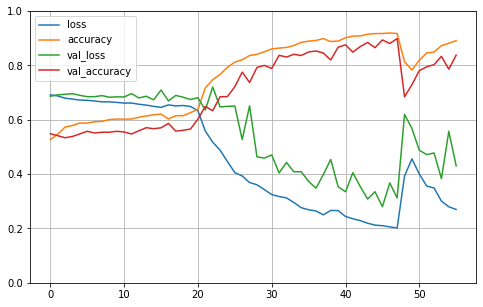

accuracy: 89.84%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 132s 343ms/step - loss: 0.6924 - accuracy: 0.5256 - val_loss: 0.6861 - val_accuracy: 0.5612


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.2.best/assets


Epoch 2/200
350/350 [==============================] - 117s 335ms/step - loss: 0.6902 - accuracy: 0.5238 - val_loss: 0.6896 - val_accuracy: 0.5297
Epoch 3/200
350/350 [==============================] - 118s 338ms/step - loss: 0.6877 - accuracy: 0.5460 - val_loss: 0.6897 - val_accuracy: 0.5477
Epoch 4/200
350/350 [==============================] - 118s 337ms/step - loss: 0.6770 - accuracy: 0.5784 - val_loss: 0.6882 - val_accuracy: 0.5464
Epoch 5/200
350/350 [==============================] - ETA: 0s - loss: 0.6749 - accuracy: 0.5848

In [ ]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model,X_valid,y_valid)  
print ("Done")